In [5]:
import pandas as pd
import os

from zipfile import ZipFile 

import tensorflow as tf


from pathlib import Path

import gc
import math
import cv2
import PIL
from PIL import Image

import matplotlib.pyplot as plt

import scipy
from tqdm.notebook import tqdm
%matplotlib inline
from keras.preprocessing import image

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.image import resize

from tensorflow import keras
from tensorflow.keras import layers


from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import numpy as np
from numpy.random import randint

from google.colab import drive

drive.mount('/content/gdrive')
google_drive_mount_path = '/content/gdrive'
google_drive_shared_path = os.path.join(google_drive_mount_path, 'My Drive' , 'Thesis/Data')

print(tf.__version__)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
2.3.0


In [2]:
pathx = os.path.join(google_drive_shared_path, 'challenge 2018 data','binary_train_images_2018_128x128.npy')
pathy = os.path.join(google_drive_shared_path, 'challenge 2018 data','binary_train_labels_2018.npy')

trainX = np.load(pathx,allow_pickle=True)
trainy = np.load(pathy,allow_pickle=True)

label_encoder = LabelEncoder()
trainy = label_encoder.fit_transform(trainy)

In [4]:
trainX.shape , trainy.shape

((7818, 128, 128, 3), (7818,))

# Conditional Wasserstein GAN with Gradient Penalty 

##Discriminator's architecture

In [6]:
IMG_SHAPE = (128, 128, 3)
BATCH_SIZE = 128

# Size of noise vector
noise_dim = 128

#fashion_mnist = keras.datasets.fashion_mnist
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = trainX
train_labels = trainy

num_classes = 2

print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# we will reshape each sample to (28, 28, 1) and normalize the pixel values in [-1, 1].
train_images = train_images.astype("float32")
train_images = (train_images - 127.5) / 127.5


Number of examples: 7818
Shape of the images in the dataset: (128, 128, 3)


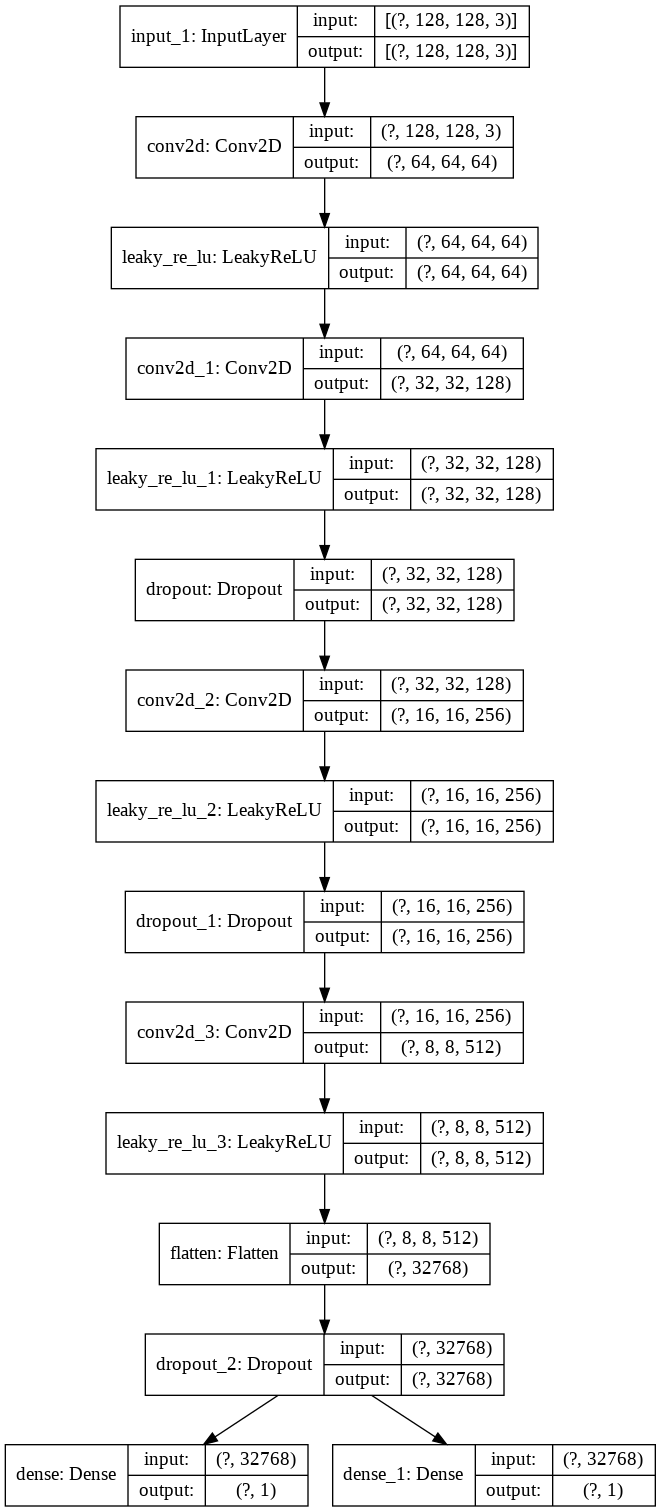

In [7]:
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x




def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    #x = layers.ZeroPadding2D((2, 2))(img_input)
    
    x = conv_block(
        img_input,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    out1 = layers.Dense(1)(x)
    out2 = layers.Dense(1,activation='sigmoid')(x)

    d_model = keras.models.Model(img_input, [out1,out2], name="discriminator")
    return d_model


d_model = get_discriminator_model()
#d_model.summary()
tf.keras.utils.plot_model(d_model, '/content/gdrive/My Drive/Thesis/conditional WGGAN-GP/architecture_discriminator.png',show_shapes=True)

## Genrator's architecture

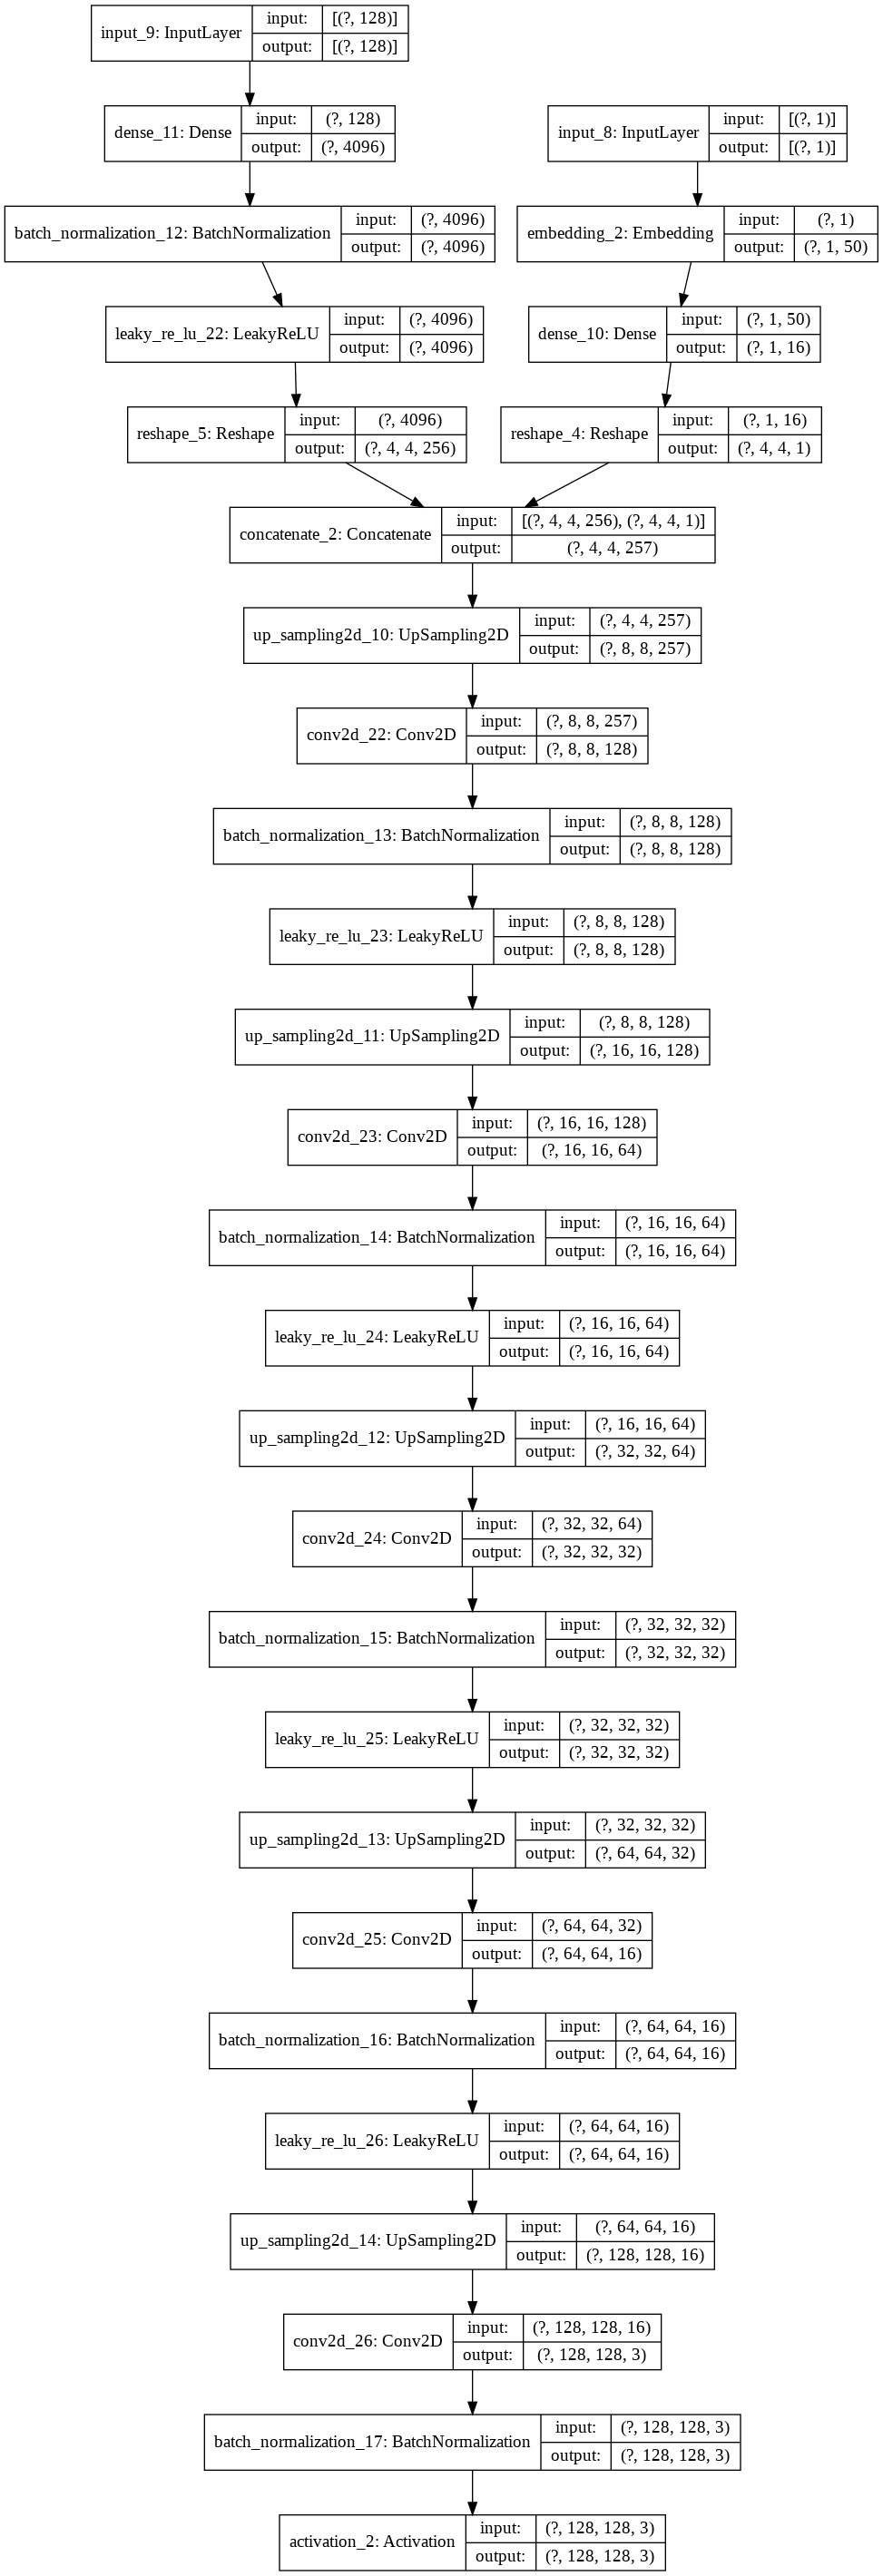

In [ ]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():

    # label input
    in_label = layers.Input(shape=(1,))
    # embedding for categorical input
    li = layers.Embedding(num_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 4 * 4
    li = layers.Dense(n_nodes)(li)
    # reshape to additional channel
    li = layers.Reshape((4, 4, 1))(li)

    noise = layers.Input(shape=(noise_dim,))

    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((4, 4, 256))(x)

    merge = layers.Concatenate()([x, li])

    x = upsample_block(
        merge,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )

    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        32,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        16,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 3, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    #x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model([noise,in_label], x, name="generator")
    return g_model


g_model = get_generator_model()
#g_model.summary()
#tf.keras.utils.plot_model(g_model)
tf.keras.utils.plot_model(g_model, '/content/gdrive/My Drive/Thesis/conditional WGGAN-GP/architecture_generator.png',show_shapes=True)

## Class GAN

In [ ]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    #def train_step(self, real_images, real_labels):
    def train_step(self, data):

        real_images, real_labels = data
        if isinstance(real_images, tuple):
            real_images = real_images[0]
            #real_labels = real_images[1]
        # Get the batch size


        batch_size = tf.shape(real_images)[0]

        real_labels = tf.cast(real_labels,tf.float32)
        real_labels = tf.convert_to_tensor(real_labels,tf.float32)
        real_images= tf.convert_to_tensor(real_images,tf.float32)


        # For each batch, we are going to perform the
        # following steps as laid out in the original paper.
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add gradient penalty to the discriminator loss
        # 6. Return generator and discriminator losses as a loss dictionary.

        # Train discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            #fake_labels = randint(0, num_classes, batch_size)
            fake_labels = tf.random.uniform(shape=(batch_size,1), minval=0,maxval=num_classes,dtype=tf.int32)
            fake_labels = tf.cast(fake_labels, tf.float32)
            
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator([random_latent_vectors,fake_labels], training=True)
                # Get the logits for the fake images
                fake_logits_source , fake_logits_label = self.discriminator(fake_images, training=True)
                #fake_labels_output = tf.argmax(fake_logits_label,axis=-1)
                fake_labels_output = tf.cast(fake_logits_label,tf.float32)
                #fake_labels_output = tf.reshape(fake_labels_output, shape=(-1,1))

                # Get the logits for real images
                real_logits_source , real_logits_label = self.discriminator(real_images, training=True)
                #real_label_output = tf.argmax(real_logits_label,axis=-1)
                real_label_output = tf.cast(real_logits_label,tf.float32)
                #real_label_output = tf.reshape(real_label_output, shape=(-1,1))

                # Calculate discriminator loss using fake and real logits
                d_cost = self.d_loss_fn[0](real_img=real_logits_source, fake_img=fake_logits_source)

                #loss_real_labels = tf.keras.losses.sparse_categorical_crossentropy(real_labels,real_logits_label)
                #loss_fake_labels = tf.keras.losses.sparse_categorical_crossentropy(fake_labels,fake_logits_label)
                
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight + self.d_loss_fn[1](real_labels,real_label_output) + self.d_loss_fn[1](fake_labels,fake_labels_output)
                #+ loss_real_labels + loss_fake_labels

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator now.
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_labels = tf.random.uniform(shape=(batch_size,1), minval=0,maxval=num_classes,dtype=tf.int32)
        fake_labels = tf.cast(fake_labels, tf.float32)
        #fake_labels = randint(0, num_classes, batch_size)

        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator([random_latent_vectors,fake_labels], training=True)
            # Get the discriminator logits for fake images
            gen_img_logits_source , gen_img_logits_labels = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            #loss_labels = tf.keras.losses.sparse_categorical_crossentropy(fake_labels,gen_img_logits_labels)
            g_loss = self.g_loss_fn[0](gen_img_logits_source) + self.g_loss_fn[1](fake_labels,gen_img_logits_labels)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=9, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        labels = tf.random.uniform(shape=(self.num_img,1), minval=0,maxval=num_classes,dtype=tf.int32)
        labels = tf.cast(labels,dtype=tf.float32)

        labels_n = labels.numpy()
        labels_n = np.squeeze(labels_n,axis=-1)
        generated_images = self.model.generator([random_latent_vectors,labels])
        generated_images = (generated_images * 127.5) + 127.5
        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            
            k = int(labels_n[i])
            img.save("/content/gdrive/My Drive/Thesis/conditional WGGAN-GP/experience2/generated_img_{i}_label{j}_epoch{epoch}.png".format(i=i, epoch=epoch,j=label_encoder.classes_[k]))
        
        square = int(np.sqrt(self.num_img))
        for i in range(self.num_img):
          img = generated_images[i].numpy()
          img = keras.preprocessing.image.array_to_img(img)
          plt.subplot(square, square, 1 + i)
          plt.axis('off')
          plt.imshow(img)
          k = int(labels_n[i])
          plt.title(label_encoder.classes_[k])
        # save plot to file
        filename1 = 'plot_%s.png' % (epoch)
        #plt.savefig(filename1)
        plt.savefig('/content/gdrive/My Drive/Thesis/conditional WGGAN-GP/experience2/'+ filename1)
        plt.close()
        # save the generator model
        filename2 = 'model_%s.h5' % (epoch)
        #self.model.generator.save(filename2)
        g_model.save('/content/gdrive/My Drive/Thesis/conditional WGGAN-GP/experience2/'+ filename2)
        print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# Optimizer for both the networks
# learning_rate=0.0002, beta_1=0.5 are recommened
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions to be used for discrimiator
# This should be (fake_loss - real_loss)
# We will add the gradient penalty later to this loss function
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions to be used for generator
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Epochs to train
epochs = 500

# Callbacks
cbk = GANMonitor(num_img=9, latent_dim=noise_dim)

# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=[generator_loss,tf.keras.losses.binary_crossentropy],
    d_loss_fn=[discriminator_loss,tf.keras.losses.binary_crossentropy],
)

#wgan.train_step(train_images,train_labels)

steps = np.ceil(train_images.shape[0]/ BATCH_SIZE) 


# Start training
wgan.fit(train_images[:-10],train_labels.reshape(-1,1)[:-10], batch_size = 128, epochs=epochs , callbacks=[cbk])

In [11]:
test_model = tf.keras.models.load_model('/content/gdrive/My Drive/Thesis/conditional WGGAN-GP/experience2/model_40.h5')

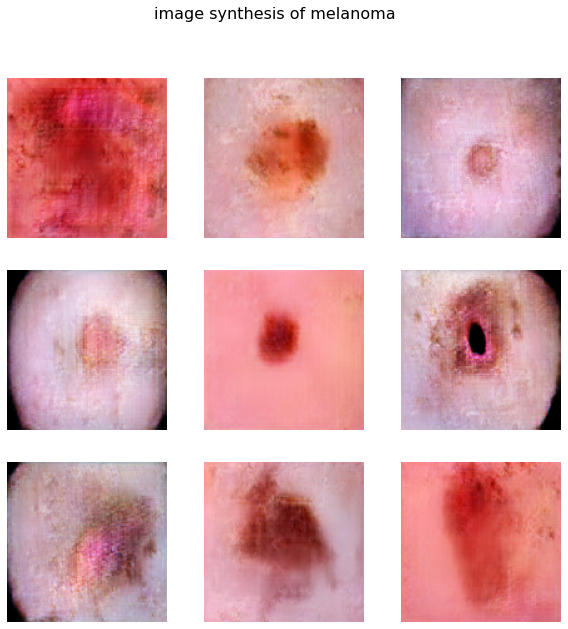

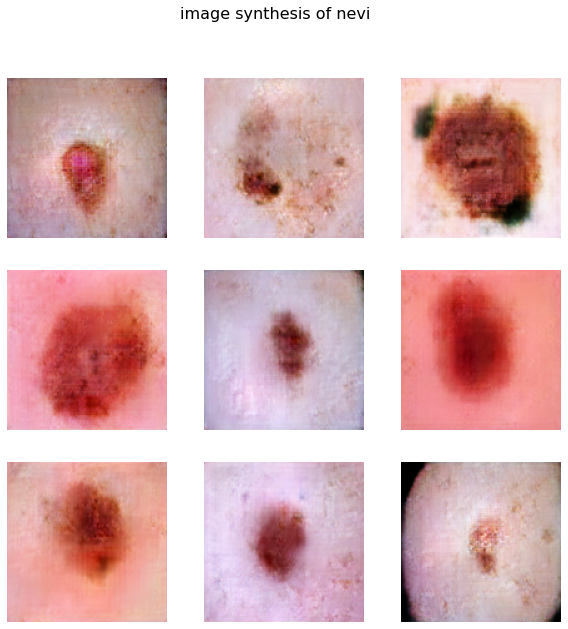

In [13]:
latent_dim = 128

random_latent_vectors_1 = tf.random.normal(shape=(9, latent_dim))
random_latent_vectors_2 = tf.random.normal(shape=(9, latent_dim))


labels_melanoma = np.zeros((9,1),dtype='float32')
labels_nevus = np.zeros((9,1),dtype='float32')
n=0

labels_n = np.squeeze(labels_melanoma,axis=-1)
generated_images = test_model([random_latent_vectors_1,labels_melanoma])
generated_images = (generated_images * 127.5) + 127.5
square = int(np.sqrt(9))
plt.figure(figsize=(10,10))
plt.suptitle("image synthesis of melanoma",fontsize=16)
for i in range(9):
  img = generated_images[i].numpy()
  img = keras.preprocessing.image.array_to_img(img)
  plt.subplot(square, square, 1 + i)
  plt.axis('off')
  plt.imshow(img)
  plt.savefig('/content/gdrive/My Drive/Thesis/conditional WGGAN-GP/image_melanoma_'+str(n)+'.png')
plt.show()
plt.close()
  
labels_n = np.squeeze(labels_nevus,axis=-1)
generated_images = test([random_latent_vectors_2,labels_nevus])
generated_images = (generated_images * 127.5) + 127.5
square = int(np.sqrt(9))
plt.figure(figsize=(10,10))
plt.suptitle("image synthesis of nevi",fontsize=16)
for i in range(9):
  img = generated_images[i].numpy()
  img = keras.preprocessing.image.array_to_img(img)
  plt.subplot(square, square, 1 + i)
  plt.axis('off')
  plt.imshow(img)
  plt.savefig('/content/gdrive/My Drive/Thesis/conditional WGGAN-GP/image_nevus_'+str(n)+'.png')
plt.show()
plt.close()

